## _Построение прогноза на горизонт для временного ряда_

Постановка задачи: по истории виброперемещений режущей кромки рабочего инструмента построить прогноз на положение инструмента на ближайшие 15 временных точек

In [171]:
import typing as t
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

from datetime import datetime
from matplotlib.axes._axes import Axes
from optuna.distributions import IntUniformDistribution, LogUniformDistribution

from sktime.forecasting.auto_reg import AutoREG
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.bats import BATS
from sktime.forecasting.tbats import TBATS
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.model_selection import ForecastingGridSearchCV, ForecastingOptunaSearchCV, ForecastingRandomizedSearchCV
from sktime.split import temporal_train_test_split
from sktime.utils.plotting import plot_series
from sktime.forecasting.compose import TransformedTargetForecaster, make_reduction, EnsembleForecaster, SkforecastAutoreg
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sktime.performance_metrics.forecasting import MeanSquaredError, mean_absolute_scaled_error, mean_absolute_percentage_error
from sktime.transformations.compose import OptionalPassthrough
from sktime.split import (
    ExpandingWindowSplitter,
    SlidingWindowSplitter,
)
from sktime.utils.plotting import plot_windows
from sktime.forecasting.trend import PolynomialTrendForecaster

from sklearn.preprocessing import RobustScaler, MinMaxScaler, PowerTransformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge

warnings.filterwarnings("ignore")

### _Константы_

In [276]:
TITLE = "Развертка виброперемещений во времени"
X_LABEL = "Относительные временные метки"
Y_LABEL = "Виброперемещение \nрежущей кромки инструмента"

TEST_SIZE = 15
BG_COLOR = "#FAFAFA"
SEED = 8888
FIGSIZE = (10, 6)
ALPHA = 0.65

### _Вспомогательные функции_

In [278]:
def make_series(
    x: np.ndarray,
    a: float = 2,
    b: float = 1.5,
    c: float = 3,
    w1: float = 3,
    w2: float = 50,
    w3: float = 10,
) -> pd.Series:
    """Строит фрагмент временного ряда"""
    
    seq = pd.Series(
        a * np.sin(w1 * x) ** 2 +
        b * np.cos(w2 * x) +
        c * np.sin(w3 * x) ** 2 +
        np.random.RandomState(SEED).randn(x.size)
    )
    # seq.index = pd.date_range(datetime.now(), periods=seq.size, freq="H")
    seq.index.name = "Period"

    return seq


def plot_context(
    seq: pd.Series,
    title: str,
    x_label: str,
    y_label: str,
    label: str,
    figsize: (int, int) = (15, 8),
    color: str = "black",
    marker: str = "o",
    alpha: float = 1.0,
    ax: t.Optional[Axes] = None,
    bg_color: str = BG_COLOR,
) -> None:
    if ax is None:
        _, ax = plt.subplots(figsize=figsize)

    ax.set_facecolor(bg_color)
        
    seq.plot(ax=ax, marker=marker, color=color, alpha=alpha, label=label)

    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

    ax.legend()

Построим последовательность положений режущей кромки инструмента во времени

In [174]:
x = np.linspace(0, 1, 500)
y = make_series(x)

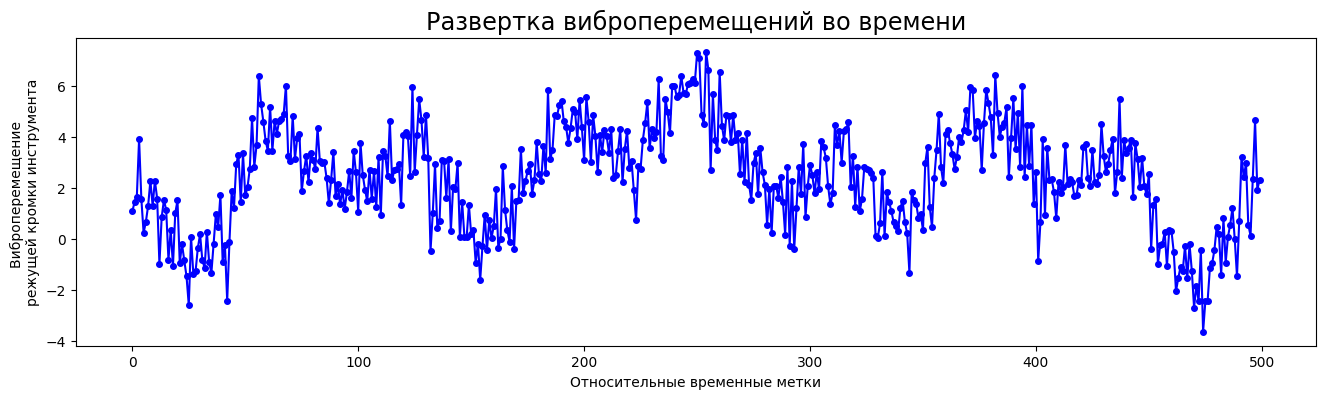

In [241]:
plot_series(
    y,
    title=TITLE,
    x_label=X_LABEL,
    y_label=Y_LABEL,
    markers=["o"],
    colors=["blue"],
);

### _Ансамбль модели Хольта-Винтерса (модели тройного экспоненциального сглаживания) и простой авторегрессии_

Разбиваем имеющийся набор данных на обучающий и тестовый поднаборы с учетом временной структуры ряда

In [180]:
y_train, y_test = temporal_train_test_split(y, test_size=15)

Создаем объект горизонта

In [198]:
fh = ForecastingHorizon(y_test.index, is_relative=False)

In [199]:
fh

ForecastingHorizon([485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498,
       499],
      dtype='int64', is_relative=False)

Создаем экземпляры базовых моделей и оборачиваем их ансамблем

In [261]:
holt_winters = ExponentialSmoothing()
auto_reg = SkforecastAutoreg(
    Ridge(), 2
)

ensemble = EnsembleForecaster([
    ("holt_winters", holt_winters),
    ("auto_reg", auto_reg),
])

Выведем перечень параметров ансамбля

In [262]:
ensemble.get_params()

{'aggfunc': 'mean',
 'forecasters': [('holt_winters', ExponentialSmoothing()),
  ('auto_reg', SkforecastAutoreg(lags=2, regressor=Ridge()))],
 'n_jobs': None,
 'weights': None,
 'holt_winters': ExponentialSmoothing(),
 'auto_reg': SkforecastAutoreg(lags=2, regressor=Ridge()),
 'holt_winters__damped_trend': False,
 'holt_winters__damping_trend': None,
 'holt_winters__initial_level': None,
 'holt_winters__initial_seasonal': None,
 'holt_winters__initial_trend': None,
 'holt_winters__initialization_method': 'estimated',
 'holt_winters__method': None,
 'holt_winters__minimize_kwargs': None,
 'holt_winters__optimized': True,
 'holt_winters__random_state': None,
 'holt_winters__remove_bias': False,
 'holt_winters__seasonal': None,
 'holt_winters__smoothing_level': None,
 'holt_winters__smoothing_seasonal': None,
 'holt_winters__smoothing_trend': None,
 'holt_winters__sp': None,
 'holt_winters__start_params': None,
 'holt_winters__trend': None,
 'holt_winters__use_boxcox': None,
 'holt_winter

Обучим ансамбль

In [263]:
ensemble.fit(y_train)

EnsembleForecaster(forecasters=[('holt_winters', ExponentialSmoothing()),
                                ('auto_reg',
                                 SkforecastAutoreg(lags=2, regressor=Ridge()))])

Строим прогноз на горизонт

In [265]:
y_pred_ensemble = ensemble.predict(fh)

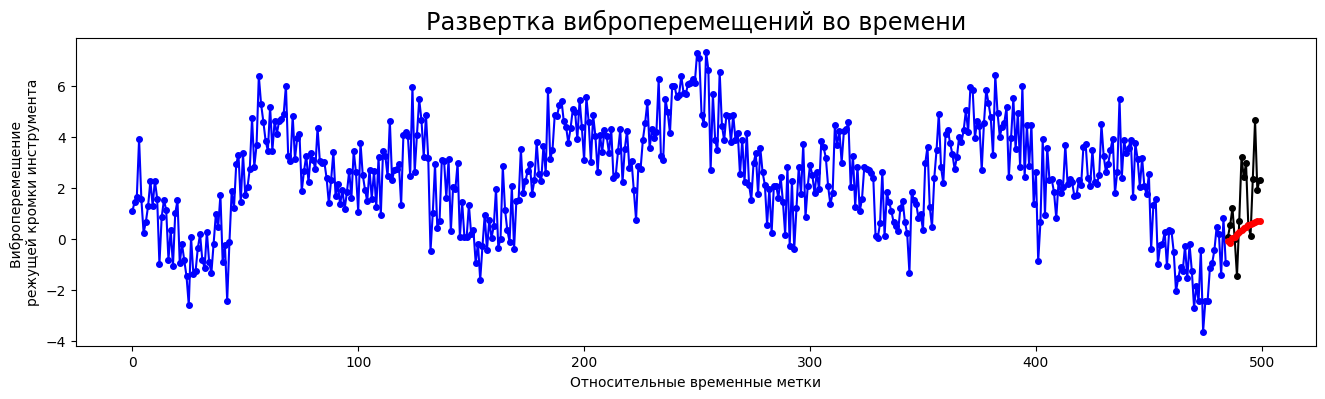

In [266]:
plot_series(
    y_train,
    y_test,
    y_pred_ensemble,
    title=TITLE,
    x_label=X_LABEL,
    y_label=Y_LABEL,
    markers=["o", "o", "o"],
    colors=["blue", "black", "red"],
);

Выведем MASE и MAPE

In [267]:
mean_absolute_scaled_error(y_test, y_pred_ensemble, y_train=y_train), mean_absolute_percentage_error(y_test, y_pred_ensemble, symmetric=True)

(1.174864394902354, 1.410567314467584)

Значения MASE > 1 указывают на то, что ансамбль базовых моделей работает хуже, чем наивная модель прогноза последним значением

### _Редукция задачи построения прогноза на горизонт к задаче обучения регрессии на табличной модальности_

Создадим экземпляр гистограммного градиентого бустинга для редукции задачи по рекурсивной стратегии

In [154]:
regressor = HistGradientBoostingRegressor()

In [206]:
forecaster = make_reduction(
    regressor,
    strategy="recursive",
)

Гиперпараметры будем подбирать с помощью перекрестной проверки на расширяющемся окне

In [207]:
cv = ExpandingWindowSplitter(
    fh.to_relative(y_train.index[-1]),  # Обзятельно нужно перейти к относительным временным меткам
    initial_window=int(len(y_train) * 0.25),
    step_length=5,
)

In [208]:
cv

ExpandingWindowSplitter(fh=ForecastingHorizon([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], dtype='int64', is_relative=True),
                        initial_window=121, step_length=5)

Выведем параметры модели

In [217]:
forecaster.get_params()

{'estimator': HistGradientBoostingRegressor(),
 'pooling': 'local',
 'transformers': None,
 'window_length': 10,
 'estimator__categorical_features': 'warn',
 'estimator__early_stopping': 'auto',
 'estimator__interaction_cst': None,
 'estimator__l2_regularization': 0.0,
 'estimator__learning_rate': 0.1,
 'estimator__loss': 'squared_error',
 'estimator__max_bins': 255,
 'estimator__max_depth': None,
 'estimator__max_features': 1.0,
 'estimator__max_iter': 100,
 'estimator__max_leaf_nodes': 31,
 'estimator__min_samples_leaf': 20,
 'estimator__monotonic_cst': None,
 'estimator__n_iter_no_change': 10,
 'estimator__quantile': None,
 'estimator__random_state': None,
 'estimator__scoring': 'loss',
 'estimator__tol': 1e-07,
 'estimator__validation_fraction': 0.1,
 'estimator__verbose': 0,
 'estimator__warm_start': False}

Зададим сетку параметров поиска

In [210]:
param_grid = {
  "window_length": [10, 15, 30],
  "estimator__max_depth": [3, 5],
  "estimator__max_iter": [100, 150],
  "estimator__l2_regularization": [0.001, 0.1],
}

Обучим модель

In [218]:
search = ForecastingGridSearchCV(
    forecaster,
    strategy="refit",
    cv=cv,
    param_grid=param_grid,
    verbose=100,
    scoring=MeanSquaredError(square_root=True),
)
search.fit(y_train)

Fitting 70 folds for each of 24 candidates, totalling 1680 fits


ForecastingGridSearchCV(cv=ExpandingWindowSplitter(fh=ForecastingHorizon([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], dtype='int64', is_relative=True),
                                                   initial_window=121,
                                                   step_length=5),
                        forecaster=RecursiveTabularRegressionForecaster(estimator=HistGradientBoostingRegressor()),
                        param_grid={'estimator__l2_regularization': [0.001,
                                                                     0.1],
                                    'estimator__max_depth': [3, 5],
                                    'estimator__max_iter': [100, 150],
                                    'window_length': [10, 15, 30]},
                        scoring=MeanSquaredError(square_root=True),
                        verbose=100)

In [219]:
search.cv_results_

,mean_test_MeanSquaredError,mean_fit_time,mean_pred_time,params,rank_test_MeanSquaredError
0,1.684298,0.128125,0.048176,"{'estimator__l2_regularization': 0.001, 'estim...",18.0
1,1.577719,0.153846,0.052501,"{'estimator__l2_regularization': 0.001, 'estim...",12.0
2,1.489016,0.205891,0.055445,"{'estimator__l2_regularization': 0.001, 'estim...",2.0
3,1.692200,0.197507,0.074384,"{'estimator__l2_regularization': 0.001, 'estim...",19.0
4,1.619871,0.222961,0.077632,"{'estimator__l2_regularization': 0.001, 'estim...",16.0
5,1.503311,0.284592,0.077780,"{'estimator__l2_regularization': 0.001, 'estim...",4.0
6,1.727301,0.205148,0.058784,"{'estimator__l2_regularization': 0.001, 'estim...",22.0
7,1.566458,0.222113,0.055178,"{'estimator__l2_regularization': 0.001, 'estim...",10.0
8,1.506400,0.350412,0.072252,"{'estimator__l2_regularization': 0.001, 'estim...",5.0
9,1.784206,0.347341,0.101243,"{'estimator__l2_regularization': 0.001, 'estim...",24.0


Посмотрим наилучшую комбинацию гиперпараметров

In [220]:
search.best_params_

{'estimator__l2_regularization': 0.1,
 'estimator__max_depth': 3,
 'estimator__max_iter': 100,
 'window_length': 30}

Наилучшей конфигурацией оказался ансмабль из 100 коротких деревьев глубины 3 с умеренной регуляризацией и размерностью признакового пространства 30

Построим прогноз на горизонт

In [268]:
y_pred_hist = search.predict(fh)

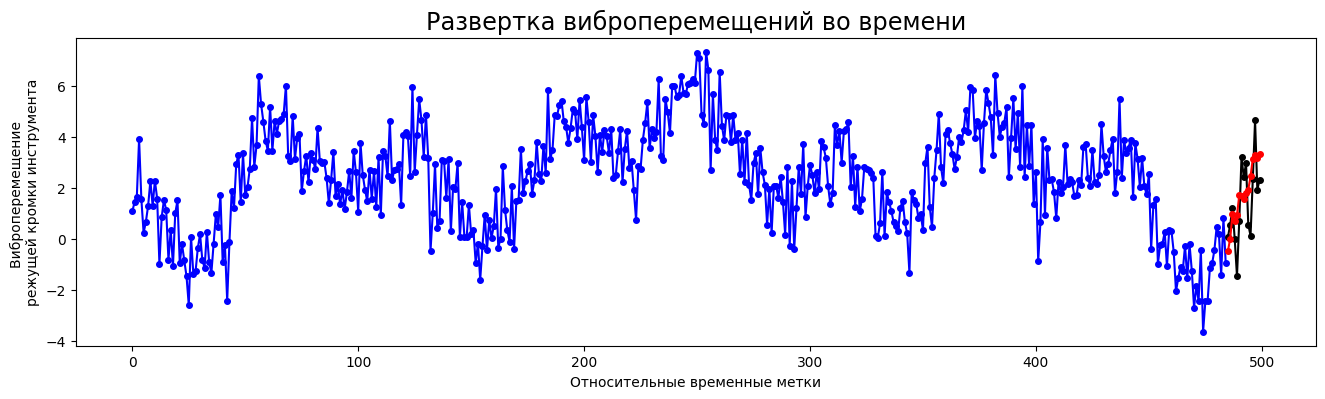

In [269]:
plot_series(
    y_train,
    y_test,
    y_pred_hist,
    title=TITLE,
    x_label=X_LABEL,
    y_label=Y_LABEL,
    markers=["o", "o", "o"],
    colors=["blue", "black", "red"],
);

Метрики MASE и MAPE улучшились, но все равно решение не очень аккуратное, хотя и улавливает тренд.

Чтобы поднять качество и повысить стабильность модели следовало бы провести анализ на предмет поиска связанных экзогенных переменных.

In [216]:
mean_absolute_scaled_error(y_test, y_pred, y_train=y_train), mean_absolute_percentage_error(y_test, y_pred, symmetric=True)

(0.9708799362620966, 0.9858189984192541)

Сводка результатов прогнозов на горизонт, полученных различными моделями

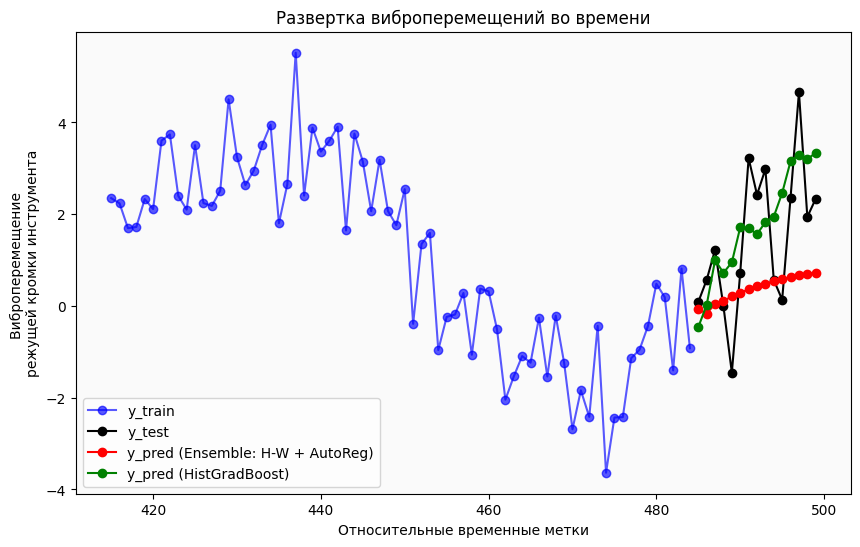

In [281]:
_, ax = plt.subplots(figsize=FIGSIZE)

fig_params = {
    "ax": ax,
    "title": TITLE,
    "x_label": X_LABEL,
    "y_label": Y_LABEL
}

plot_context(y_train.iloc[-70:], color="blue", label="y_train", alpha=ALPHA, **fig_params)
plot_context(y_test, color="black", label="y_test", **fig_params)
plot_context(y_pred_ensemble, color="red", label="y_pred (Ensemble: H-W + AutoReg)", **fig_params)
plot_context(y_pred_hist, color="green", label="y_pred (HistGradBoost)", **fig_params)